In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Indian_Extent = pd.read_excel(filepath, sheet_name='Indian-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Indian_Extent)
fp.date_time(Indian_Extent)

,Extent,Date
0,376618.799,1979-01-01
1,211788.726,1979-02-01
2,262868.141,1979-03-01
3,698377.304,1979-04-01
4,1252407.727,1979-05-01
...,...,...
533,1520776.003,2023-06-01
534,2076164.165,2023-07-01
535,2731799.027,2023-08-01
536,3179384.692,2023-09-01


In [5]:
scaler = MinMaxScaler()
Indian_Extent['Extent'] = scaler.fit_transform(Indian_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 12
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Indian_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((515, 12, 1), (515,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Indian_model_LT12/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 16s 198ms/step - loss: 0.2541 - root_mean_squared_error: 0.5041 - val_loss: 0.1650 - val_root_mean_squared_error: 0.4062
Epoch 2/50
53/53 [==============================] - 9s 175ms/step - loss: 0.1529 - root_mean_squared_error: 0.3910 - val_loss: 0.0930 - val_root_mean_squared_error: 0.3049
Epoch 3/50
53/53 [==============================] - 9s 177ms/step - loss: 0.0997 - root_mean_squared_error: 0.3158 - val_loss: 0.0856 - val_root_mean_squared_error: 0.2926
Epoch 4/50
53/53 [==============================] - 9s 180ms/step - loss: 0.0863 - root_mean_squared_error: 0.2937 - val_loss: 0.0690 - val_root_mean_squared_error: 0.2626
Epoch 5/50
53/53 [==============================] - 10s 186ms/step - loss: 0.0719 - root_mean_squared_error: 0.2682 - val_loss: 0.0614 - val_root_mean_squared_error: 0.2477
Epoch 6/50
53/53 [==============================] - 10s 186ms/step - loss: 0.0545 - root_mean_squared_error: 0.2335 - val_loss: 0.0499 - v

Epoch 37/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0532
Epoch 38/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0609
Epoch 39/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0059 - root_mean_squared_error: 0.0767 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0756
Epoch 40/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567
Epoch 41/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0660
Epoch 42/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0036 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

3.390031961599986 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

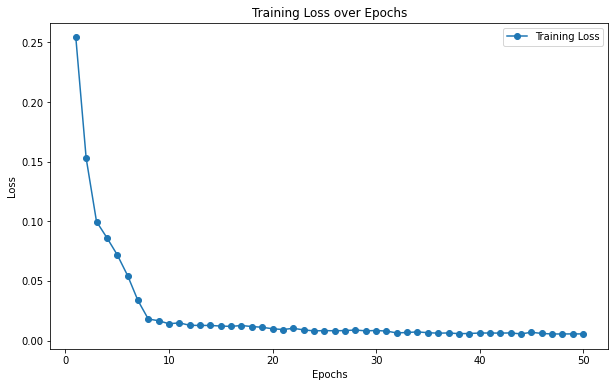

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

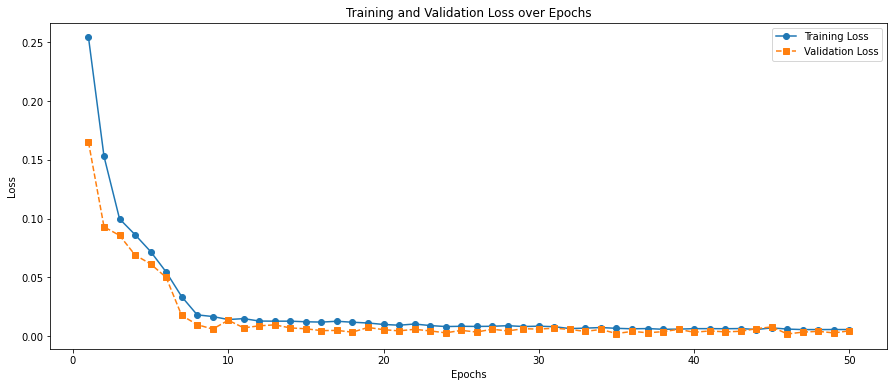

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Indian_model_LT12/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 12ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.05113464832195927
MAE : 0.042725468067007416


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,5.855162e+05,827036.916
1,1.117923e+06,1142021.216
2,1.734694e+06,1885693.654
3,2.396759e+06,2542569.663
4,3.050774e+06,3107373.845
5,3.514820e+06,3488175.444
6,3.529038e+06,3746306.528
7,3.011909e+06,2942322.822
8,1.656028e+06,1507212.955
9,6.015167e+05,648507.437


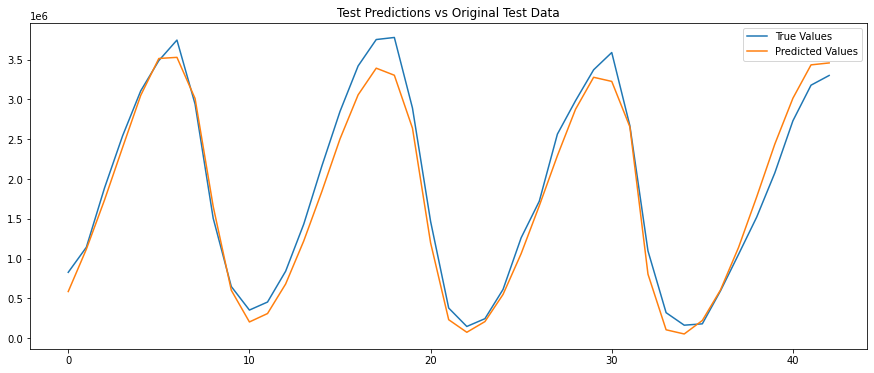

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 14ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

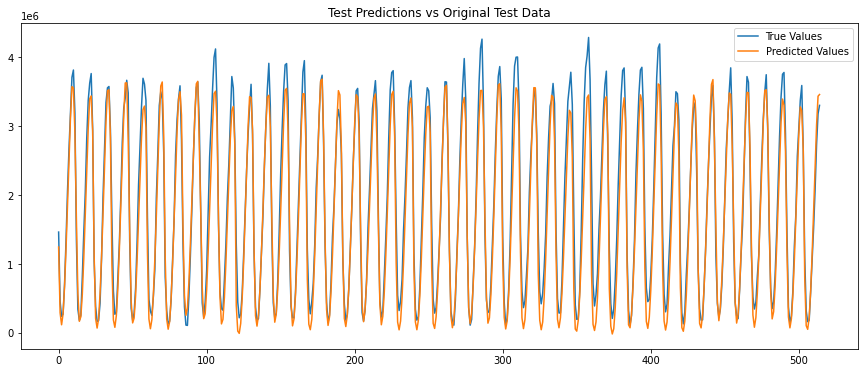

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()